# Plots optode data for specified depth 
Also plot inflection points
- Update `BASE_ZIP_PATH` or `BASE_DIR` to point to your data.
- The code expects file names like `SMORES optode_6 3 inch.csv` and columns including `Epoch`, `DO`, `T`.

In [17]:

import os, re, math, zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Matplotlib defaults
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True


In [18]:

# === Configure data location ===
# If your files are in a zip, set BASE_ZIP_PATH and run the extraction cell.
BASE_ZIP_PATH = 'CSVperOptode_2.zip'   # change if needed
EXTRACT_DIR = '/home/raman-pc/smores_proj/CSVperOptode/'          # change if needed

# If you already have a folder with CSVs, set BASE_DIR and skip extraction.
BASE_DIR = EXTRACT_DIR


In [19]:

# Optional: extract from zip if the folder doesn't already exist
# import os
# if BASE_ZIP_PATH and not os.path.exists(EXTRACT_DIR):
    # with zipfile.ZipFile(BASE_ZIP_PATH, 'r') as zf:
        # zf.extractall(EXTRACT_DIR)
print('Data directory:', BASE_DIR)
for root, _, files in os.walk(BASE_DIR):
    print(f'  {len(files)} files in {root}')

Data directory: /home/raman-pc/smores_proj/CSVperOptode/
  52 files in /home/raman-pc/smores_proj/CSVperOptode/


In [20]:

def parse_info(fname):
    """Return (optode_id, depth_inch) from filename like 'SMORES optode_6 3 inch.csv'"""
    m = re.search(r'optode_(\d+)\s+(\d+)\s+inch', os.path.basename(fname))
    if not m:
        return None, None
    return int(m.group(1)), int(m.group(2))

# Collect csv files
csv_files = []
for root, _, files in os.walk(BASE_DIR):
    for f in files:
        if f.endswith('.csv') and 'optode_' in f:
            csv_files.append(os.path.join(root, f))

len(csv_files), csv_files[:5]


(26,
 ['/home/raman-pc/smores_proj/CSVperOptode/SMORES optode_14 1 inch.csv',
  '/home/raman-pc/smores_proj/CSVperOptode/SMORES optode_13 6 inch.csv',
  '/home/raman-pc/smores_proj/CSVperOptode/SMORES optode_3 3 inch.csv',
  '/home/raman-pc/smores_proj/CSVperOptode/SMORES optode_2 1 inch.csv',
  '/home/raman-pc/smores_proj/CSVperOptode/SMORES optode_27 3 inch.csv'])

In [21]:

# Read all CSVs robustly and standardize columns
records = []
for path in csv_files:
    oid, depth = parse_info(path)
    if oid is None:
        continue
    try:
        df = pd.read_csv(path)
    except UnicodeDecodeError:
        df = pd.read_csv(path, encoding='latin1')
    # Ensure required columns exist
    colmap = {c.strip(): c for c in df.columns}
    if 'Epoch' not in colmap or 'DO' not in colmap:
        continue
    df = df[[colmap['Epoch'], colmap['DO']]].rename(columns={colmap['Epoch']: 'Epoch', colmap['DO']: 'DO'})
    df['file'] = os.path.basename(path)
    df['optode_id'] = oid
    df['depth_inch'] = depth
    records.append(df)

all_df = pd.concat(records, ignore_index=True)
all_df['datetime'] = pd.to_datetime(all_df['Epoch'], unit='s', utc=True)
all_df['datetime'] = all_df['datetime'].dt.tz_convert('US/Eastern')
print('Rows:', len(all_df), ' | Optodes:', all_df.optode_id.nunique(), ' | Depths:', sorted(all_df.depth_inch.unique()))
all_df.head()


Rows: 17187  | Optodes: 26  | Depths: [np.int64(1), np.int64(3), np.int64(6)]


,Epoch,DO,file,optode_id,depth_inch,datetime
0,1.744035e+09,8.344990,SMORES optode_14 1 inch.csv,14,1,2025-04-07 10:13:20.283986568-04:00
1,1.744035e+09,8.344559,SMORES optode_14 1 inch.csv,14,1,2025-04-07 10:14:14.122994900-04:00
2,1.744035e+09,8.324755,SMORES optode_14 1 inch.csv,14,1,2025-04-07 10:15:06.377996206-04:00
3,1.744035e+09,8.318866,SMORES optode_14 1 inch.csv,14,1,2025-04-07 10:15:58.537986517-04:00
4,1.744035e+09,8.308474,SMORES optode_14 1 inch.csv,14,1,2025-04-07 10:16:50.894986629-04:00


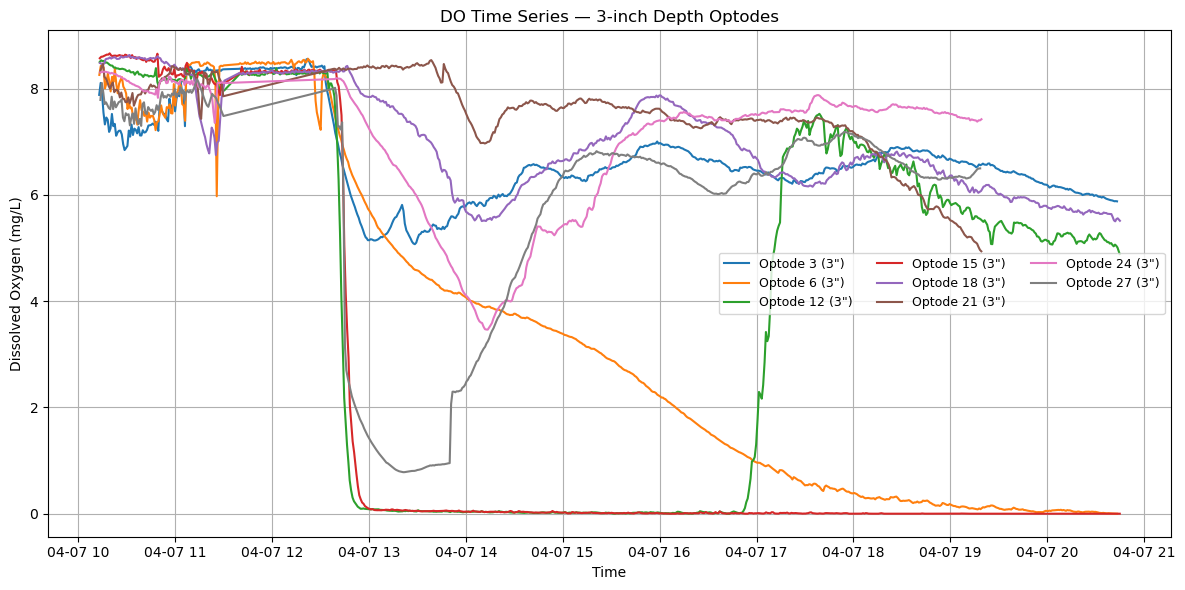

In [22]:

three_inch = all_df[all_df['depth_inch'] == 3].copy().sort_values(['optode_id','datetime'])

plt.figure(figsize=(12,6))
for oid, sub in three_inch.groupby('optode_id'):
    plt.plot(sub['datetime'], sub['DO'], label=f'Optode {oid} (3\")')
plt.xlabel('Time')
plt.ylabel('Dissolved Oxygen (mg/L)')
plt.title('DO Time Series — 3-inch Depth Optodes')
plt.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.show()


Let's aggregate the 9 optodes into 1 and plot inflection points

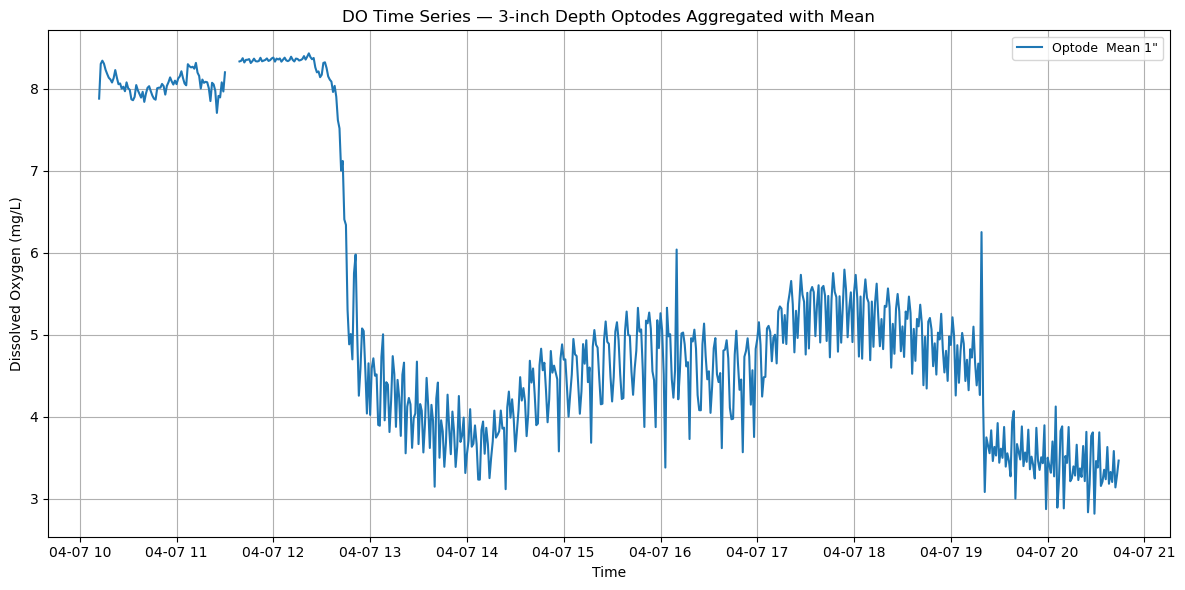

In [ ]:
three_inch["datetime"] = pd.to_datetime(three_inch["datetime"])
three_inch_mean = (
    three_inch.resample("1min", on="datetime")["DO"]
    .mean()
    .reset_index()
)


plt.figure(figsize=(12,6))

plt.plot(three_inch_mean['datetime'], three_inch_mean['DO'], label=f'Optode  Mean 3"')
plt.xlabel('Time')
plt.ylabel('Dissolved Oxygen (mg/L)')
plt.title('DO Time Series — 3-inch Depth Optodes Aggregated with Mean')
plt.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.show()

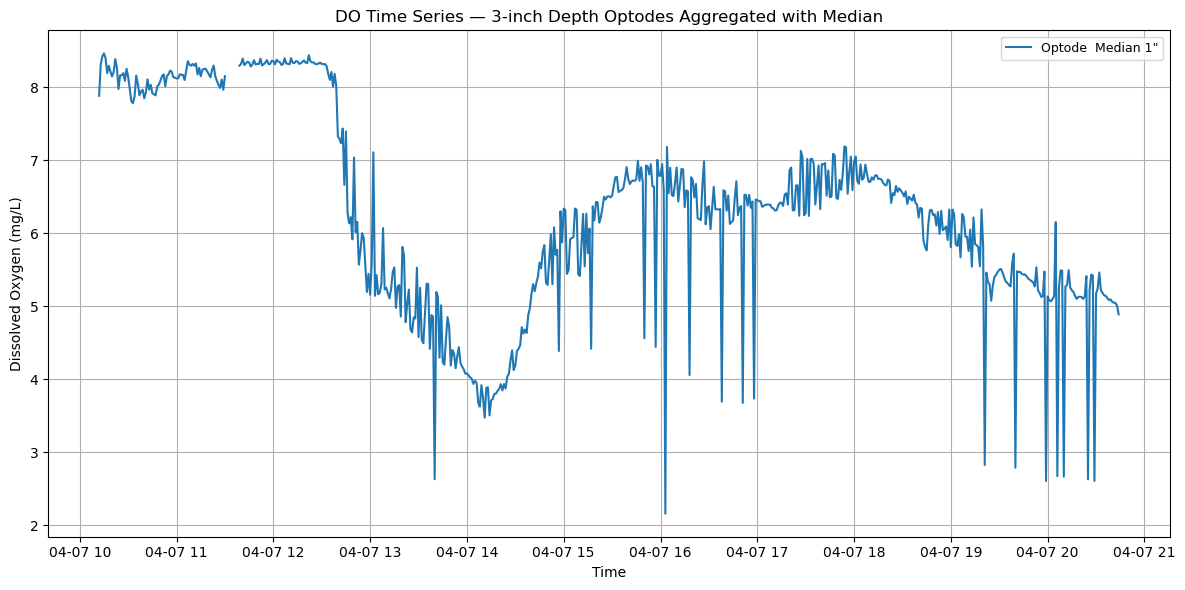

In [ ]:
three_inch["datetime"] = pd.to_datetime(three_inch["datetime"])
three_inch_median = (
    three_inch.resample("1min", on="datetime")["DO"]
    .median()
    .reset_index()
)
plt.figure(figsize=(12,6))

plt.plot(three_inch_median['datetime'], three_inch_median['DO'], label=f'Optode  Median 3"')
plt.xlabel('Time')
plt.ylabel('Dissolved Oxygen (mg/L)')
plt.title('DO Time Series — 3-inch Depth Optodes Aggregated with Median')
plt.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.show()

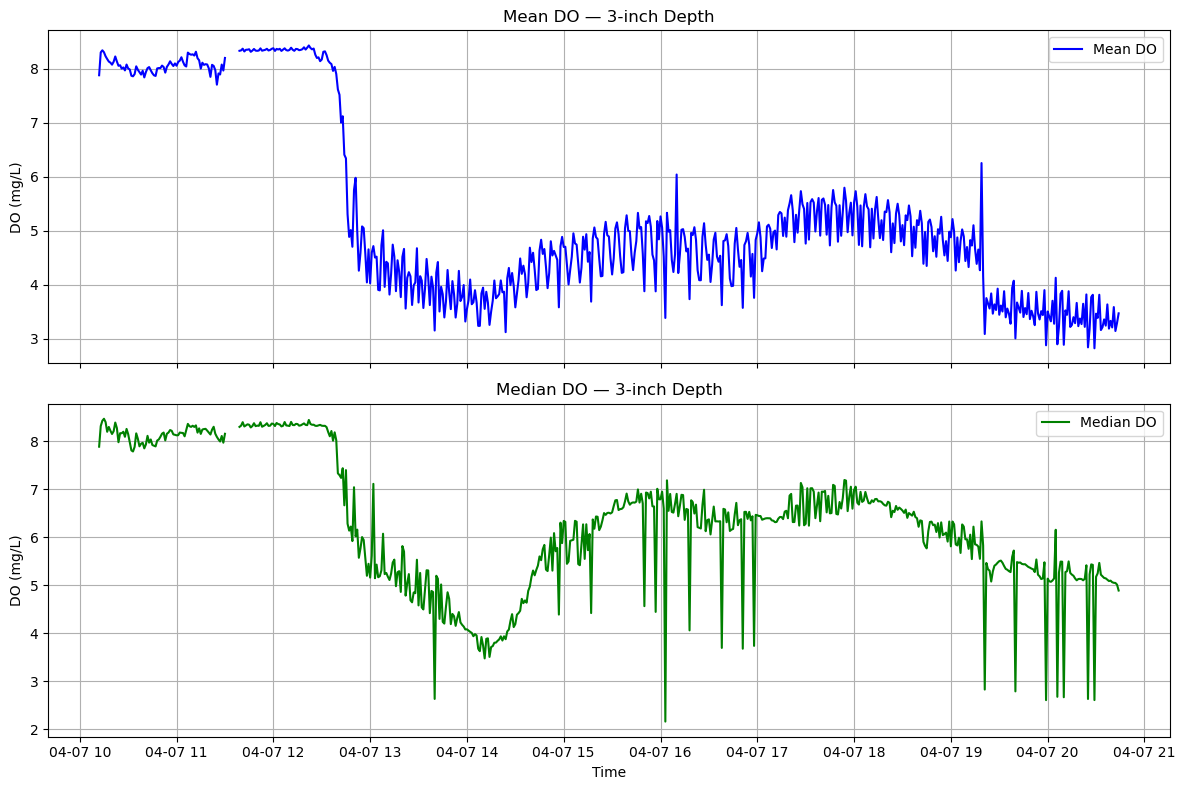

In [25]:
three_inch["datetime"] = pd.to_datetime(three_inch["datetime"])
agg_stats = (
    three_inch
    .resample("1min", on="datetime")["DO"]
    .agg(["mean", "median"])
    .reset_index()
)
# Create two vertically stacked plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Mean plot
ax1.plot(agg_stats["datetime"], agg_stats["mean"], color="blue", label="Mean DO")
ax1.set_title("Mean DO — 3-inch Depth")
ax1.set_ylabel("DO (mg/L)")
ax1.legend()

# Median plot
ax2.plot(agg_stats["datetime"], agg_stats["median"], color="green", label="Median DO")
ax2.set_title("Median DO — 3-inch Depth")
ax2.set_xlabel("Time")
ax2.set_ylabel("DO (mg/L)")
ax2.legend()

plt.tight_layout()
plt.show()

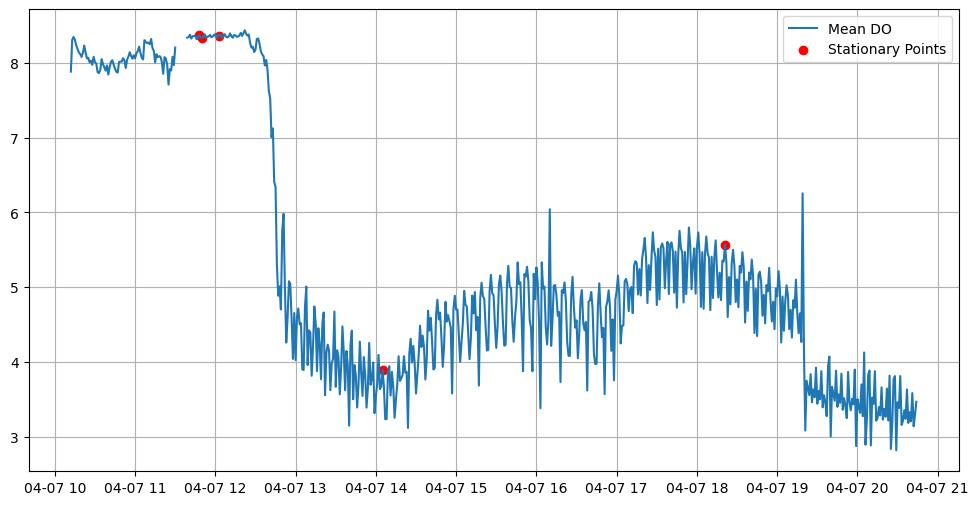

In [26]:
import numpy as np
agg_stats["dDOmean"] = np.gradient(agg_stats["mean"])
# Stationary points where slope ~ 0
eps = 1e-3
stationary_idx = agg_stats.index[np.isclose(agg_stats["dDOmean"], 0, atol=eps)]
plt.figure(figsize=(12,6))
plt.plot(agg_stats["datetime"], agg_stats["mean"], label="Mean DO")
plt.scatter(agg_stats.loc[stationary_idx, "datetime"], agg_stats.loc[stationary_idx, "mean"], color="red", label="Stationary Points")
plt.legend()
plt.show()

In [27]:
from prophet import Prophet
agg_stats['datetime'] = agg_stats['datetime'].dt.tz_localize(None)
df_prophet = agg_stats.rename(columns={"datetime": "ds", "mean": "y"})
m = Prophet(
    changepoint_prior_scale=0.05,   # sensitivity: larger = more changepoints
    changepoint_range=0.9           # portion of history where changepoints can occur
)
m.fit(df_prophet)
# Changepoint times
changepoints = m.changepoints

# Trend rate (delta) at each changepoint
import pandas as pd
cp_info = pd.DataFrame({
    "changepoint": m.changepoints,
    "delta": m.params["delta"].mean(0)  # average effect across samples
})

16:59:48 - cmdstanpy - INFO - Chain [1] start processing
16:59:48 - cmdstanpy - INFO - Chain [1] done processing


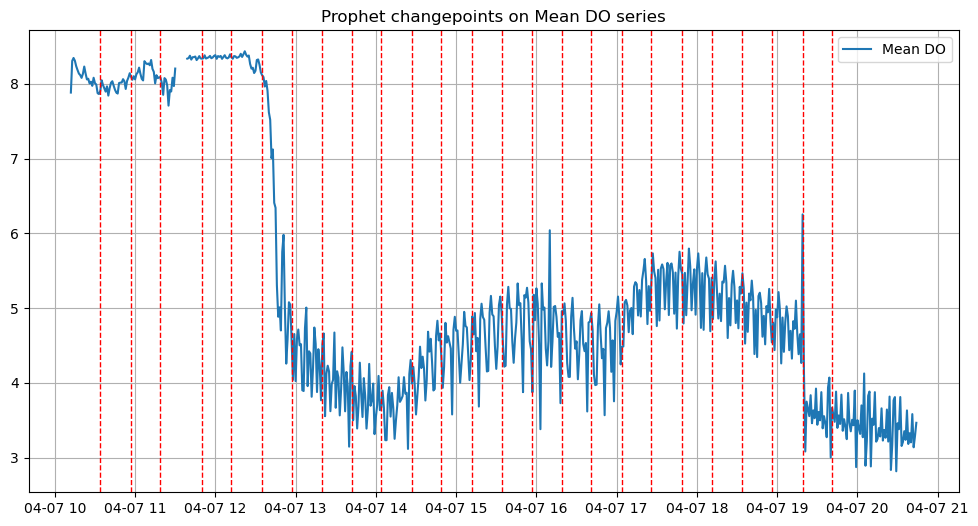

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(df_prophet["ds"], df_prophet["y"], label="Mean DO")
for cp in changepoints:
    ax.axvline(cp, color="red", ls="--", lw=1)
ax.set_title("Prophet changepoints on Mean DO series")
ax.legend()
plt.show()

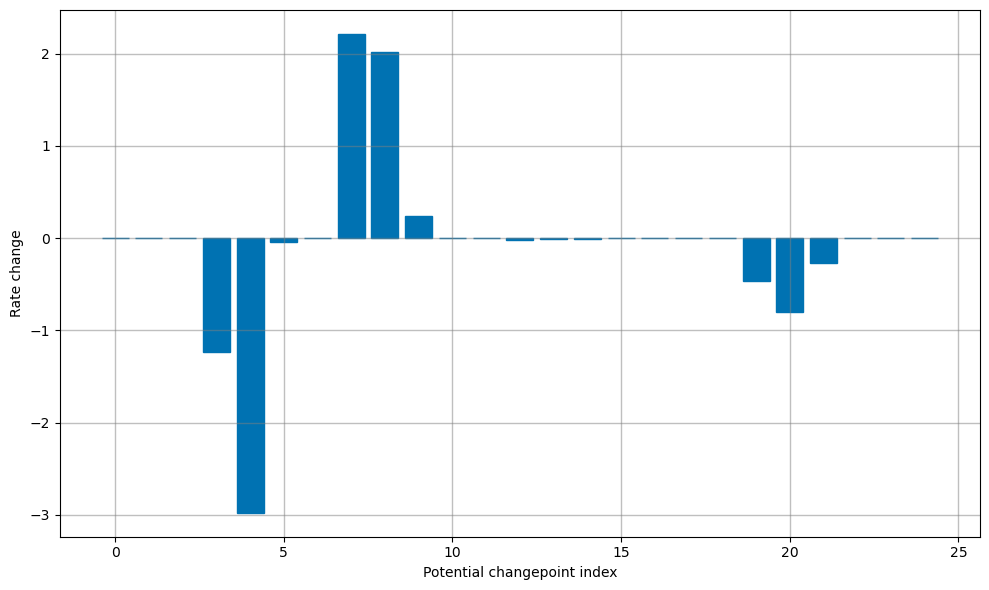

In [29]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor='w', figsize=(10,6))
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas, facecolor='#0072B2', edgecolor="#0072B2")
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.5)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint index')
fig.tight_layout()

In [30]:
deltas

array([-3.19413e-08,  9.29703e-10,  2.70658e-08, -1.23103e+00,
       -2.97603e+00, -3.85507e-02,  1.72774e-04,  2.21207e+00,
        2.01351e+00,  2.37931e-01,  3.43193e-08, -5.39583e-06,
       -1.97805e-02, -5.84666e-03, -1.22887e-02, -2.65824e-08,
       -2.08900e-08,  3.43658e-09, -2.53613e-09, -4.63807e-01,
       -7.98245e-01, -2.68496e-01, -1.68282e-08, -4.04487e-08,
       -2.93025e-09])

In [31]:

from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

NameError: name 'forecast' is not defined